### Bibliotecas

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import os

### Importando datos

In [2]:
path = '/home/faber/EK_AutoNOMOS_Sim/src/autonomos_gazebo_simulation/scripts'
passingDir = path + '/dataTRAIN'
passingImagesDir = passingDir + '/dataset_passing'
#passingImages = !ls -1 '{passingImagesDir}'
passingImages = os.listdir(passingImagesDir)

print('Imágenes de ciudad: ', len(passingImages))

Imágenes de ciudad:  12636


In [3]:
lidarCSV = passingDir + '/lidar.csv'
outputsCSV = passingDir + '/outputs.csv'

outputs = pd.read_csv(outputsCSV, names=['angle', 'speed'], sep='\t').astype(np.float32)
lidar = pd.read_csv(lidarCSV, sep='\t', header=None).astype(np.float32)
lidar = lidar.iloc[: , :-1]

print("Diferencia entre tamaño de los DF y numero de imgs: ")
print((len(outputs) - len(passingImages)))
print((len(lidar) - len(passingImages)))

data = pd.concat([outputs, lidar], axis=1, join='inner')
#data['img'] = passingImages.sort(nums = True)
data['img'] = sorted(passingImages, key=lambda x:int(x.replace('_camara.png', '')))
data['img'] = data['img'].astype("string")

cols = data.columns.tolist()
cols = cols[-1:] + cols[:-1]
data = data[cols]

Diferencia entre tamaño de los DF y numero de imgs: 
0
0


In [4]:
#lidar.head()
#outputs.head()
data.head()
#data.dtypes

,img,angle,speed,0,1,2,3,4,5,6,...,350,351,352,353,354,355,356,357,358,359
0,1_camara.png,90.0,0.0,1.36,1.36,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,1.36,1.36,1.36,1.36,1.36,1.36
1,2_camara.png,90.0,0.0,1.36,1.36,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,1.36,1.36,1.36,1.36,1.36,1.36
2,3_camara.png,90.0,0.0,1.36,1.36,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,1.36,1.36,1.36,1.36,1.36,1.36
3,4_camara.png,90.0,0.0,1.36,1.36,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,1.36,1.36,1.36,1.36,1.36,1.36
4,5_camara.png,90.0,-800.0,1.36,1.36,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,1.36,1.36,1.36,1.36,1.36,1.36


### Visualizando datos

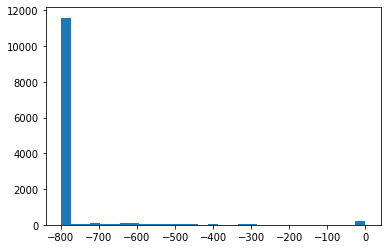

In [5]:
plt.hist(data['speed'], bins = 31)
plt.show()

In [ ]:
def binningData(nbins, samplesPerBin, data):
  hist, bins = np.histogram(data['speed'].to_numpy(), nbins)
  removeIndexList = []
  for j in range(nbins):
    binDataList = []
    for i in range(len(data['speed'])):
      if data['speed'][i] >= bins[j] and data['speed'][i] <= bins[j+1]:
        binDataList.append(i)
    binDataList = shuffle(binDataList)
    binDataList = binDataList[samplesPerBin:]
    removeIndexList.extend(binDataList)
  print('Removed images: ', len(removeIndexList))
  data.drop(data.index[removeIndexList], inplace=True)
  print('Remaining images: ', len(data))

In [ ]:
binningData(31, 800, data)

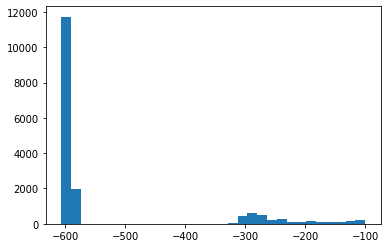

In [ ]:
plt.hist(data['speed'], bins = 31)
plt.show()

### Input pipeline

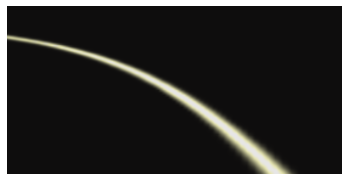

out:  (0.6555555555555554, -1.0)


In [6]:
def crop(inimg):
  #image = inimg[270:405, :, :]
  image = inimg[220:405, :, :]
  image = tf.image.resize(image, [180, 360])
  #image = tf.image.rgb_to_yuv(image) # Lo he probado con YUV, pero no he visto mejoras perceptibles
  return image

def normalize(image):
  #inImg = (image/127.5) - 1  # normaliza de 0 a 255 -> -1 a 1
  inImg = image/255           # normaliza de 0 a 255 -> 0 a 1
  return inImg

def loadPista(filename, angle, speed, lidar, dir, flip = False, augment = False):
  inImg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(dir + '/' + filename)), tf.float32)[...,:3]
  #inImg = tf.image.adjust_contrast(inImg, 2)
  #inImg = tf.image.adjust_brightness(inImg, delta = 0.1) # udacity simulator

  # aumentación de datos aleatoria
  if augment:
    if np.random.rand() < 0.5:
      inImg = tf.image.random_hue(inImg, .2)
    if np.random.rand() < 0.5:
      inImg = tf.image.random_saturation(inImg, 1, 3)
    if np.random.rand() < 0.5:
      inImg = tf.image.random_brightness(inImg, 0.5)
    if np.random.rand() < 0.5:
      inImg = tf.image.random_contrast(inImg, 0.4, 1)

  inImg = normalize(inImg)
  inImg = crop(inImg)
  
  # se invierte la imágen horizontalmente y si se hace, se invirte el ángulo
  if flip:
    inImg = tf.image.flip_left_right(inImg)
    angle = angle * -1
    lidar = lidar[::-1]

  # el último paso de la aumentación de datos es un corte aleatorio al que después
  # se le cambia el tamaño para que pueda ser procesado por la red
  if augment:
    if np.random.rand() < 0.5:
      inImg = tf.image.random_crop(value=inImg, size=(150, 300, 3))
      #inImg = tf.image.resize(inImg, [66, 200])
      inImg = tf.image.resize(inImg,  [180, 360])

  angle = ((angle/180)*2)-1
  speed = speed/800
  outputs = (angle, speed)

  # lidar as img
  lidar = lidar[::-1]
  #lidar.astype('float32')
  lidar = tf.roll(lidar, 180, axis = 0)
  lidar /= 3
  lidarImg = [
              lidar,
              lidar,
              lidar,
              lidar,
              lidar,
              lidar,
              lidar,
              lidar,
              lidar,
              lidar,
              lidar,
              lidar,
              lidar,
              lidar,
              lidar,
              lidar,
              lidar,
              lidar,
              ]
  lidarImg = [lidarImg,lidarImg,lidarImg]
  lidarImg = tf.transpose(lidarImg,[1, 2, 0])
  inputs = (inImg, lidarImg)
  return inputs, outputs



# Prueba función de load
row = data.iloc[4120] #de 3900 a 4030 hay un rebase después del binning a 800 en speed en el primer dataset
lidarVector = row[3:363].to_numpy().astype('float32')
image, angle = loadPista(row['img'], row['angle'], row['speed'], lidarVector, passingImagesDir, flip=False, augment=True)
#plt.title('Imagen de prueba: ' + urlsPista2_manual[0])
#plt.imshow((image + 1) / 2)    # Si se normalizó de -1 a 1
plt.imshow(image[0])               # Si se normalizó de 0 a 1
plt.axis('off')
plt.show()
plt.imshow(image[1])               # Si se normalizó de 0 a 1
plt.axis('off')
plt.show()
print('out: ', angle)
#plt.imshow(tf.cast(tf.image.decode_jpeg(tf.io.read_file(passingImagesDir + '/' + row['img'])), tf.uint8)[...,:3])

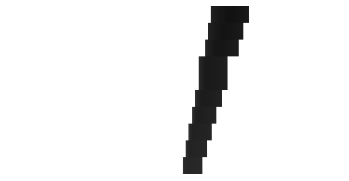

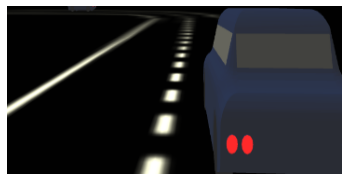

out:  (<tf.Tensor: shape=(), dtype=float32, numpy=-1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=-1.0>)
(10, 180, 360, 3)
(1, 180, 360, 3)
2


In [7]:
def loadTimeData(now, aumentar=False, voltear = False):
  #now = 4150 + 1
  #now += 1
  imagesList = data['img'].tolist()
  datos = data.drop(['img'], axis=1)
  dataList = datos.values.tolist()
  imagesList = tf.convert_to_tensor(imagesList)
  dataMatrix = tf.convert_to_tensor(dataList)
  """video = []
  radar = []
  for i in range(now-10,  now):
    row = dataMatrix[i]
    #row = normalizer(data.iloc[i])
    #lidarVector = row[3:363].to_numpy().astype('float32')
    #lidarVector = np.asarray(row[3:363]).astype(np.float32)
    #lidarVector = tf.constant(row[3:363].values, tf.float32)
    #lidarVector = np.array(row[3:363])
    #lidarVector = tf.cast(row[cols].values, tf.float32)
    #print(lidarVector)
    inputs, output = loadPista(imagesList[i], row[0], row[1], row[2::], passingImagesDir, flip=voltear, augment=aumentar)
    radar.append(inputs[1])
    video.append(inputs[0])"""

  row = dataMatrix[now]
  inputs, output = loadPista(imagesList[now], row[0], row[1], row[2::], passingImagesDir, flip=voltear, augment=aumentar)
  row = dataMatrix[now-1]
  inputs1, output1 = loadPista(imagesList[now-1], row[0], row[1], row[2::], passingImagesDir, flip=voltear, augment=aumentar)
  row = dataMatrix[now-2]
  inputs2, output2 = loadPista(imagesList[now-2], row[0], row[1], row[2::], passingImagesDir, flip=voltear, augment=aumentar)
  row = dataMatrix[now-3]
  inputs3, output3 = loadPista(imagesList[now-3], row[0], row[1], row[2::], passingImagesDir, flip=voltear, augment=aumentar)
  row = dataMatrix[now-4]
  inputs4, output4 = loadPista(imagesList[now-4], row[0], row[1], row[2::], passingImagesDir, flip=voltear, augment=aumentar)
  row = dataMatrix[now-5]
  inputs5, output5 = loadPista(imagesList[now-5], row[0], row[1], row[2::], passingImagesDir, flip=voltear, augment=aumentar)
  row = dataMatrix[now-6]
  inputs6, output6 = loadPista(imagesList[now-6], row[0], row[1], row[2::], passingImagesDir, flip=voltear, augment=aumentar)
  row = dataMatrix[now-7]
  inputs7, output7 = loadPista(imagesList[now-7], row[0], row[1], row[2::], passingImagesDir, flip=voltear, augment=aumentar)
  row = dataMatrix[now-8]
  inputs8, output8 = loadPista(imagesList[now-8], row[0], row[1], row[2::], passingImagesDir, flip=voltear, augment=aumentar)
  row = dataMatrix[now-9]
  inputs9, output9 = loadPista(imagesList[now-9], row[0], row[1], row[2::], passingImagesDir, flip=voltear, augment=aumentar)
    
  radarImg = tf.concat([inputs[1],inputs1[1],inputs2[1],inputs3[1],inputs4[1],inputs5[1],inputs6[1],inputs7[1],inputs8[1],inputs9[1]], axis=0)
  radarImg = tf.expand_dims(radarImg, axis=0)
  video = tf.stack([inputs9[0], inputs8[0], inputs7[0], inputs6[0], inputs5[0], inputs4[0],inputs3[0], inputs2[0], inputs1[0], inputs[0]])
  inputs = (video, radarImg)
  outputs = output
  return (inputs, outputs)


input, output = loadTimeData(4010)

plt.imshow(input[1][0])
plt.axis('off')
plt.show()

plt.imshow(input[0][0])
plt.axis('off')
plt.show()
print('out: ', output)
print(input[0].shape)
print(input[1].shape)
print(len(output))
#print(len(video))

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML, Video

# np array with shape (frames, height, width, channels)
video = input[0]

fig = plt.figure()
im = plt.imshow(video[0,:,:,:])

plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[0,:,:,:])

def animate(i):
    im.set_data(video[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=50)
HTML(anim.to_jshtml())
#Video(anim.to_html5_video())
#print(anim.to_jshtml())

In [9]:
rangoImgs = list(range(len(data)))
#print(rangoImgs)

dataset_p1 = tf.data.Dataset.from_tensor_slices((
    rangoImgs,
    ))
dataset_p1 = dataset_p1.map(lambda x: loadTimeData(x, aumentar=False, voltear=False), )

dataset_p2 = tf.data.Dataset.from_tensor_slices((
    rangoImgs,
    ))
dataset_p2 = dataset_p2.map(lambda x: loadTimeData(x, aumentar = True, voltear=False), )

""" dataset_p3 = tf.data.Dataset.from_tensor_slices((
    rangoImgs,
    ))
dataset_p3 = dataset_p3.map(lambda x: loadTimeData(x, aumentar = True, voltear=False), )

dataset_p4 = tf.data.Dataset.from_tensor_slices((
    rangoImgs,
    ))
dataset_p4 = dataset_p4.map(lambda x: loadTimeData(x, aumentar = True, voltear=False), )

dataset_p5 = tf.data.Dataset.from_tensor_slices((
    rangoImgs,
    ))
dataset_p5 = dataset_p5.map(lambda x: loadTimeData(x, aumentar = True, voltear=False), ) """

#fullDataset = dataset_p1.concatenate(dataset_p2)
fullDataset = dataset_p2
#fullDataset = fullDataset.concatenate(dataset_p3)
#fullDataset = fullDataset.concatenate(dataset_p4)
#fullDataset = fullDataset.concatenate(dataset_p5)
fullDataset = fullDataset.batch(16) #16 max
DATASET_SIZE = fullDataset.cardinality().numpy()
#fullDataset = fullDataset.shuffle(DATASET_SIZE)

train_size = int(1 * DATASET_SIZE)
val_size = int(0 * DATASET_SIZE)

print("Tamaño del dataset en lotes (batches): ", DATASET_SIZE)
print("Tamaño del dataset de entrenamiento en lotes (batches): ", train_size)
print("Tamaño del dataset de validacipon en lotes (batches): ", val_size)

train_dataset = fullDataset.take(train_size)
val_dataset = fullDataset.skip(train_size)

Tamaño del dataset en lotes (batches):  790
Tamaño del dataset de entrenamiento en lotes (batches):  790
Tamaño del dataset de validacipon en lotes (batches):  0


### RED

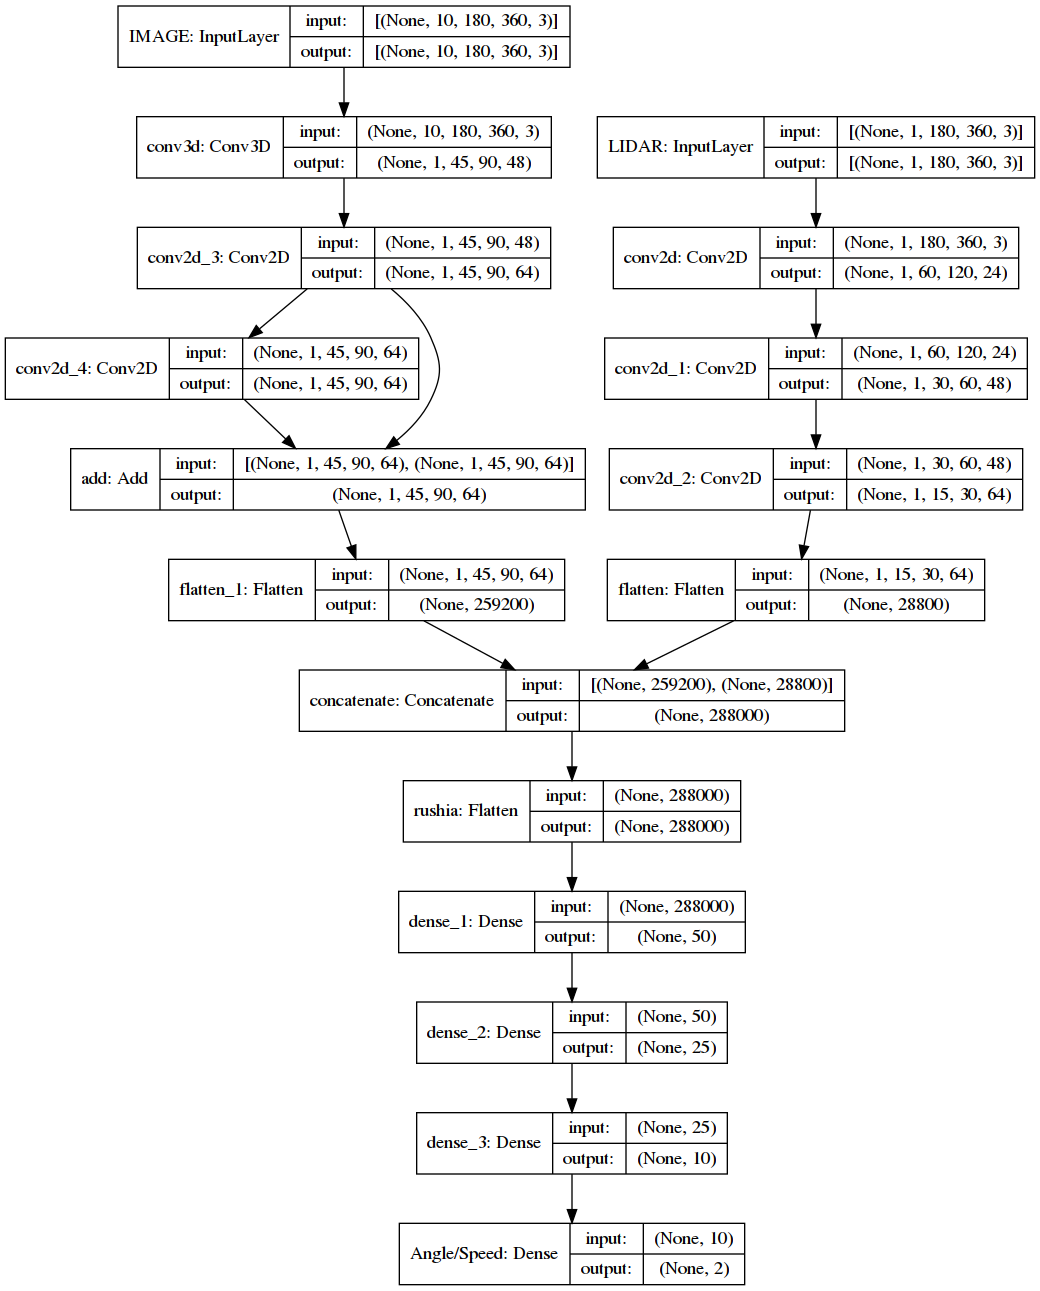

In [10]:
# Red
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

initializer = tf.random_normal_initializer(0., 0.04)

# Inputs
video = keras.Input(shape=([10, 180, 360, 3]), name="IMAGE")
lidar = keras.Input(shape=([1, 180, 360, 3]), name="LIDAR")

### Layers ###
## Layers lidar
#conv2d1 =  layers.Conv2D(12, 5, 3, activation='relu', padding='SAME', kernel_initializer = initializer)(lidar)
conv2d2 =  layers.Conv2D(24, 5, 3, activation='relu', padding='SAME', kernel_initializer = initializer)(lidar)
conv2d3 =  layers.Conv2D(48, 3, 2, activation='relu', padding='SAME', kernel_initializer = initializer)(conv2d2)
conv2d4 =  layers.Conv2D(64, 3, 2, activation='relu', padding='SAME', kernel_initializer = initializer)(conv2d3)
#(none, 1, 15, 30, 64)
#maxpool2 = layers.MaxPool3D(pool_size=(1,1,3), strides=2, padding='valid')(conv2d4)
maxpool2 = layers.Flatten()(conv2d4)
#(1,7,14,64)

## layers video 
#m0 = layers.concatenate([video, lidar], axis=1)
conv3dVideo1 = layers.Conv3D(48, (10,5,5), (10,4,4), padding = "same", activation='relu')(video)
conv2dVideo1 = layers.Conv2D(64, (3,3), padding = "same", activation='relu')(conv3dVideo1)
conv2dVideo2 = layers.Conv2D(64, (3,3), padding = "same", activation='relu')(conv2dVideo1)
#(none, 1, 45, 90, 64)
#m1 = layers.concatenate([conv3dVideo1, conv2d1], axis=1)
maxpool1 = layers.Flatten()(layers.add([conv2dVideo2,conv2dVideo1]))
#(1,22,44,64)

# Dense layers
m2 = layers.concatenate([maxpool1, maxpool2])

rushia = layers.Flatten(name = "rushia")(m2)
dense1 = layers.Dense(100, activation="relu")(rushia)
dense2 = layers.Dense(50, activation="relu")(rushia)
dense3 = layers.Dense(25, activation="relu")(dense2)
dense4 = layers.Dense(10, activation="sigmoid")(dense3)


# Outputs
dirVel = layers.Dense(2, name="Angle/Speed")(dense4)

model = keras.Model(
    inputs = [video, lidar],
    outputs = [dirVel]
)

#model.add(tf.keras.layers.Input(shape = [66, 200, 3]))


opt = tf.keras.optimizers.Adam()
model.compile(
    #loss='mean_absolute_error',
    #loss = 'mean_squared_error',
    loss = 'mean_absolute_percentage_error',
    metrics = 'mean_absolute_error',
    optimizer= opt
    )

#print(model.summary())
keras.utils.plot_model(model, show_shapes = True)

In [42]:
for layer in model.layers:
    #layer.trainable = True
    #print(layer.trainable)
    if "conv" in layer.name:
        print('-------------')
        layer.trainable = False
        print(layer.name)
        print(layer.trainable)

#print(model.layers[-1].name)
""" model.layers[-1].trainable = True
print('-------------')
print(model.layers[-1].name)
print(model.layers[-1].trainable) """


-------------
conv3d_18
False
-------------
conv2d_93
False
-------------
conv2d_90
False
-------------
conv2d_94
False
-------------
conv2d_91
False
-------------
conv2d_92
False


" model.layers[-1].trainable = True\nprint('-------------')\nprint(model.layers[-1].name)\nprint(model.layers[-1].trainable) "

In [43]:
history = model.fit(
    train_dataset,
    epochs = 1,
    #validation_data = val_dataset
    )
#model.fit(train_dataset, epochs = 1)

1053/1053 [==============================] - 2296s 2s/step - loss: 1364905.0000 - mean_absolute_error: 0.0911


In [44]:
# Guarda el modelo
model.save(path +'/models/RevaseC3V0.h5')

/home/faber/.local/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
#import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open(path + '/RevaseC3V0.tflite', 'wb') as f:
  f.write(tflite_model)

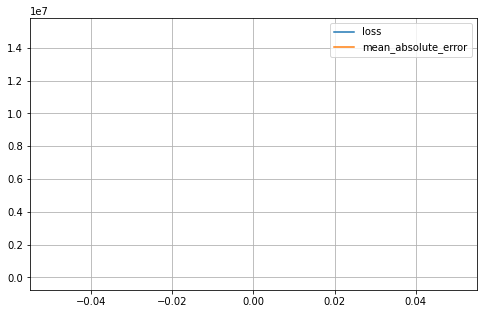

In [34]:
pd.DataFrame(history.history).plot(figsize = (8, 5))
plt.grid(True)
#plt.ylim((0,1))
plt.show()

In [45]:
#for testImage, angle in train_dataset.take(10):
  #pass


predict = model(testImage, training = False)

#plt.imshow((testImage[0, ...] + 1) / 2)   # Si se normalizó de -1 a 1
#plt.imshow(testImage[0, ...])              # Si se normalizó de 0 a 1
#plt.axis('off')
#plt.show()
print('predict: ', predict.numpy()[0][0], predict.numpy()[0][1])
print('Truth: ', angle[0].numpy(), angle[1].numpy())

predict:  -0.0007619038 0.013203479
Truth:  [0.17777777] [-0.75]
